In [68]:
import numpy as np
import scipy as sci
import math
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from scipy.odr import ODR, Model, Data
import matplotlib.pyplot as plt 
import pandas as pd

In [69]:
def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

def linear(x, a, b):
    return a*x + b

En este documento se reportan los resultados obtenidos en la práctica de Torque Magnético. El principal objetivo de esta práctica es determinar el momento angular magnético de la bola de resina. Esto se hace  por medio de tres técnicas. Adicionalmente, queremos evidenciar cualitativamente el fenómeno de resonancia magnética.
Empecemos con el cálculo del momento magnético $\mu$. En la primera actividad se presenta un enfoque teóricamente ingenioso, pero ineficiente en la práctica. Le colocamos una varilla de masa $M$ con una tuerca  de masa $m$. Esto inducirá unos torques adicionales que queremos que se equilibren para cierto valor de $B$. La relación que usaremos ser'a
\begin{equation}
rmg= \mu B -DMg.
\end{equation}
Donde $r$ es la distancia del eje de giro hasta la pesa y $D$ la distancia del eje de giro hasta el centro de masa de la varilla. Modificamos $B$ al variar la corriente. Estos se relacionan con esta regla
$$B=1.356 \times 10^{-3} \frac{T}{A} \cdot I. $$
Notemos que para estimar $\mu$ solo requerimos de la pendiente de la ecuación (1). Antes de graficar reportamos las constantes, con sus incertidumbres, que usaremos a lo largo de esta bitácora.

Parámetros ajustados: a = 0.39903047891184673 ± 0.03392860688599989, b = -0.0005550674032830044 ± 0.00011206343221971935


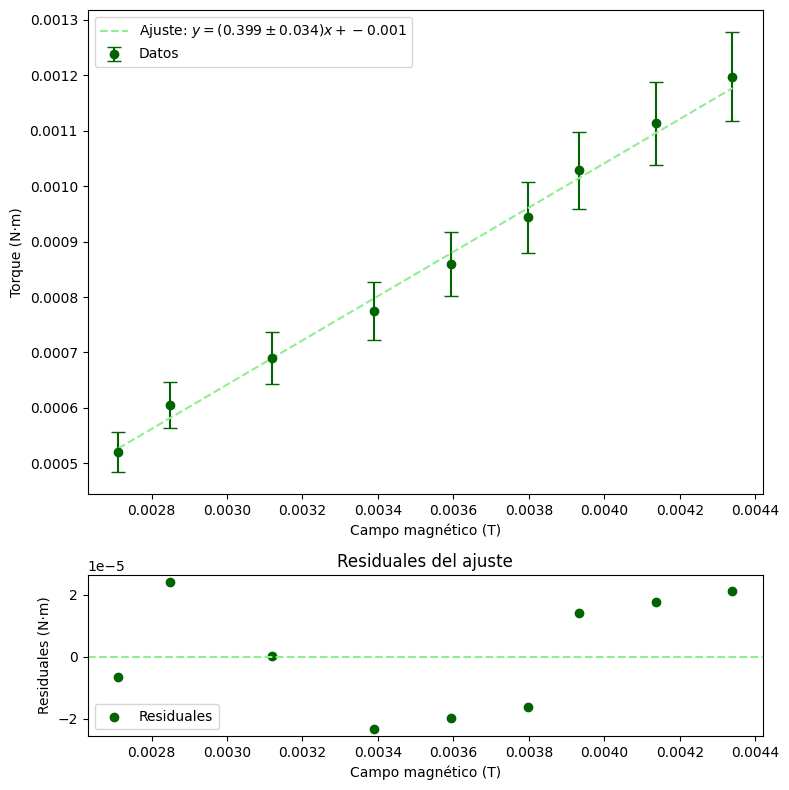

In [70]:

# Función modelo lineal
def linear(x, a, b):
    return a * x + b

# Parámetros y constantes
diametro, inc_d = 5.165, 0.025  # cm
campo = 1.356 * (10**(-3))  # T
manija, inc_mani = 0.955, 0.025  # cm
masa_p, inc_p = 1.5, 0.1  # g
gravedad = 9.81  # m/s^2
masa_vara, inc_vara = 1.2, 0.1  # g
masa_bola, inc_bola = 141.3, 0.1  # g
longitud_p, inc_long_vara = 1.15, 0.025  # cm
long_var_meti, inc_long_meti = 6.165, 0.025  # cm

# Conversión de unidades (cm a m, g a kg)
diametro, inc_d = diametro / 100, inc_d / 100  # cm a m
manija, inc_mani = manija / 100, inc_mani / 100  # cm a m
masa_p, inc_p = masa_p / 1000, inc_p / 1000  # g a kg
masa_vara, inc_vara = masa_vara / 1000, inc_vara / 1000  # g a kg
masa_bola, inc_bola = masa_bola / 1000, inc_bola / 1000  # g a kg
longitud_p, inc_long_vara = longitud_p / 100, inc_long_vara / 100  # cm a m
long_var_meti, inc_long_meti = long_var_meti / 100, inc_long_meti / 100  # cm a m

# Cargar datos
data = pd.read_excel("Torque magnético.xlsx", sheet_name="Hoja2")
distancias = data['d cm +-0,05cm'].to_numpy() / 100 + (diametro / 2) + manija  # cm a m
corriente = data['I (A)+-0,05A'].to_numpy()
campo_magnetico = campo * corriente  # T


dispersion=np.sqrt((inc_d/2)**2+(inc_mani)**2+(0.05/100)**2)
inc_distancias=dispersion*np.ones(len(distancias))
# Calcular rmg (torque) y su incertidumbre
rmg = masa_p * gravedad * distancias  # N·m
inc_y = np.sqrt(
    (masa_p * gravedad * inc_distancias)**2 +  # Error por distancias
    (gravedad * distancias * inc_p)**2  # Error por masa_p
)  # N·m

# Datos para el ajuste
x = campo_magnetico  # Variable independiente (campo magnético, T)
y = rmg  # Variable dependiente (torque, N·m)
y_err = inc_y  # Incertidumbre en y (N·m)

# Ajuste con curve_fit
popt, pcov = curve_fit(linear, x, y, sigma=y_err, absolute_sigma=True)

# Parámetros ajustados y errores
a, b = popt
a_err, b_err = np.sqrt(np.diag(pcov))  # Errores estándar de a y b

# Mostrar resultados
print(f"Parámetros ajustados: a = {a} ± {a_err}, b = {b} ± {b_err}")

parametros=Error(a,a_err)

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

# Gráfica de datos y ajuste
ax[0].errorbar(x, y, yerr=y_err, fmt='o', color='darkgreen', label='Datos', capsize=5)
ax[0].plot(x, linear(x, *popt), '--', color='lightgreen', label=f'Ajuste: $y = ({popt[0]:.3f} \pm {a_err:.3f})x + {popt[1]:.3f}$')
ax[0].set_xlabel('Campo magnético (T)')
ax[0].set_ylabel('Torque (N·m)')
ax[0].legend()


# Gráfica de residuales
residuales = y - linear(x, *popt)  # Cálculo de residuales
ax[1].scatter(x, residuales, color='darkgreen', label='Residuales')
ax[1].axhline(0, color='lightgreen', linestyle='--')
ax[1].set_xlabel('Campo magnético (T)')
ax[1].set_ylabel('Residuales (N·m)')
ax[1].legend()
ax[1].set_title('Residuales del ajuste')

# Ajustar diseño para que no haya sobreposición
plt.tight_layout()
plt.show()

Podemos apreciar unos buenos residuales, bastante aleatorios. El valor para $\mu$ al que llegamos fue de $0.40  \pm 0.03. Ahora para la actividad 3, debido a una confusión en la guía y despiste, tomamos solo 3 datos...entonces las gráficas van a ser muy poco confiables.

Parámetros ajustados: a = 603.6062694341379 ± 3.5101675061356277, b = 0.3727006659021959 ± 0.005892228500888367
Momento magnético: mu = 0.357 ± 0.002


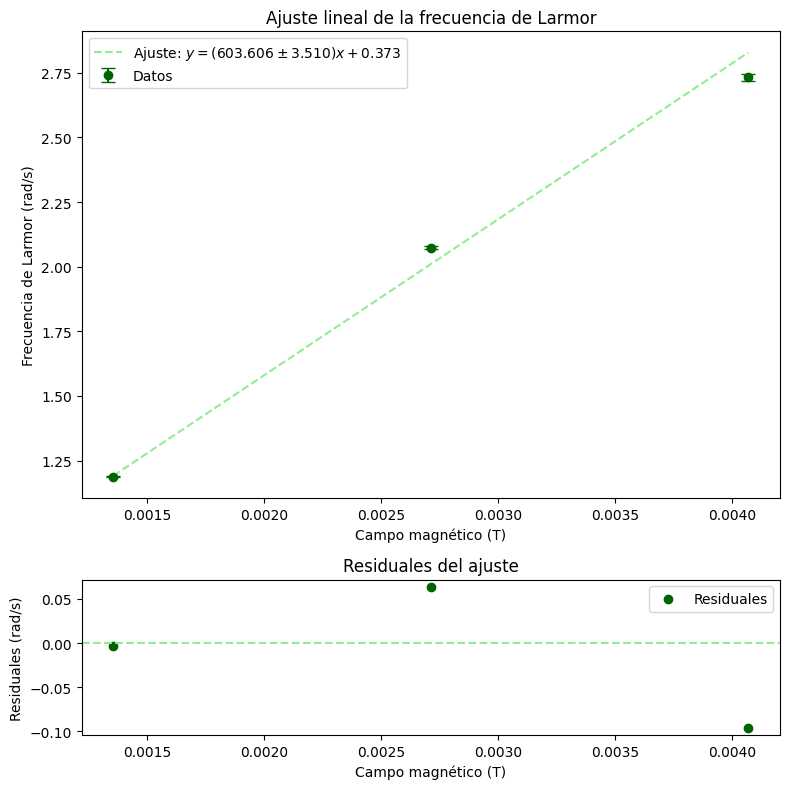

Campo magnético calculado: [0.001356 0.002712 0.004068]
Frecuencia de Larmor calculada: [1.1877477  2.07365852 2.7318197 ]
Semilla para el ajuste: a_teorico = 675.5496926620132, b_teorico = 0
Momento de inercia I: 3.7694918925000006e-05


In [72]:

# Constantes y parámetros
f_O = 2.5  # Frecuencia del ostroboscopio en Hz
inc_T = 0.01  # Incertidumbre del periodo en s
 # Campo magnético en T (constante del laboratorio)



# Momento de inercia de la bola
inercia = (2/5) * masa_bola * (diametro/2)**2  # kg·m^2

# Cargar datos
data = pd.read_excel("Torque magnético.xlsx", sheet_name="Hoja4")
corriente = data['I (A)+-0,05A'].to_numpy()  # Corriente en A
periodo = data['T (s) +- 0,05s'].to_numpy()  # Periodo en s

# Calcular el campo magnético
campo_magnetico = campo * corriente  # T

# Calcular la frecuencia de Larmor (Omega)
Omega = (2 * np.pi) / periodo  # rad/s

inc_y = ((2 * np.pi / periodo**2) * inc_T)  # Propagación de errores para Omega


y_err = inc_y  # Incertidumbre en y (rad/s)

# Seed (valores iniciales) basada en el valor teórico de mu
mu_teorico = 0.4  # Valor teórico de mu en J/T o A·m^2
a_teorico = mu_teorico / (2 * np.pi * f_O*inercia)  # Pendiente teórica en (rad/s)/T
b_teorico = 0  # Intercepto teórico (debe ser cercano a cero)
seed = [a_teorico, 0]  # Seed para el ajuste

# Ajuste con curve_fit
popt, pcov = curve_fit(linear, campo_magnetico, Omega, sigma=y_err, absolute_sigma=True, p0=seed)

# Parámetros ajustados y errores
a, b = popt
a_err, b_err = np.sqrt(np.diag(pcov))  # Errores estándar de a y b

# Calcular el momento magnético mu
mu = a * inercia * (2 * np.pi * f_O)
mu_err = a_err * inercia * (2 * np.pi * f_O)

mu,mu_err=Error(mu,mu_err)
# Mostrar resultados
print(f"Parámetros ajustados: a = {a} ± {a_err}, b = {b} ± {b_err}")
print(f"Momento magnético: mu = {mu} ± {mu_err}")
# Crear la figura con dos subgráficos
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

# Gráfica de datos y ajuste
ax[0].errorbar(campo_magnetico, Omega, yerr=y_err, fmt='o', color='darkgreen', label='Datos', capsize=5)
ax[0].plot(campo_magnetico, linear(campo_magnetico, *popt), '--', color='lightgreen', label=f'Ajuste: $y = ({popt[0]:.3f} \pm {a_err:.3f})x + {popt[1]:.3f}$')
ax[0].set_xlabel('Campo magnético (T)')
ax[0].set_ylabel('Frecuencia de Larmor (rad/s)')
ax[0].legend()
ax[0].set_title('Ajuste lineal de la frecuencia de Larmor')

# Gráfica de residuales
residuales = Omega - linear(campo_magnetico, *popt)  # Cálculo de residuales
ax[1].scatter(campo_magnetico, residuales, color='darkgreen', label='Residuales')
ax[1].axhline(0, color='lightgreen', linestyle='--')
ax[1].set_xlabel('Campo magnético (T)')
ax[1].set_ylabel('Residuales (rad/s)')
ax[1].legend()
ax[1].set_title('Residuales del ajuste')

# Ajustar diseño para que no haya sobreposición
plt.tight_layout()
plt.show()

print(f"Campo magnético calculado: {campo_magnetico}")
print(f"Frecuencia de Larmor calculada: {Omega}")
print(f"Semilla para el ajuste: a_teorico = {a_teorico}, b_teorico = {b_teorico}")
print(f"Momento de inercia I: {inercia}")